# 🌬️ XGboost-based Wind Power Forecasting in DK1

Predict wind power generation in DK1 (Western Denmark) using 10m wind speed from Aarhus.

In [3]:
# 1. Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import joblib

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 2. Load datasets

df_weather = pd.read_csv('../data/weather.csv', parse_dates=['utc_timestamp'])
df_wind = pd.read_csv('../data/wind_power.csv', parse_dates=['utc_timestamp'])

# Normalize timezones to avoid merge issues
df_weather['utc_timestamp'] = df_weather['utc_timestamp'].dt.tz_localize(None)
df_wind['utc_timestamp'] = df_wind['utc_timestamp'].dt.tz_localize(None)

# Merge on timestamp
df = pd.merge(df_weather, df_wind, on='utc_timestamp')
df.rename(columns={df.columns[-1]: 'wind_power_actual'}, inplace=True)
df.head()

,utc_timestamp,windspeed_10m,wind_power_actual
0,2016-01-01 00:00:00,3.805556,830.31
1,2016-01-01 01:00:00,3.444444,701.10
2,2016-01-01 02:00:00,3.388889,696.06
3,2016-01-01 03:00:00,3.611111,699.83
4,2016-01-01 04:00:00,3.777778,747.99


In [3]:
# 3. Feature engineering

df['hour'] = df['utc_timestamp'].dt.hour
df['month'] = df['utc_timestamp'].dt.month
df['dayofweek'] = df['utc_timestamp'].dt.dayofweek

# Add lag feature
df['lag1'] = df['windspeed_10m'].shift(1)
df.dropna(inplace=True)
df.head()

,utc_timestamp,windspeed_10m,wind_power_actual,hour,month,dayofweek,lag1
1,2016-01-01 01:00:00,3.444444,701.10,1,1,4,3.805556
2,2016-01-01 02:00:00,3.388889,696.06,2,1,4,3.444444
3,2016-01-01 03:00:00,3.611111,699.83,3,1,4,3.388889
4,2016-01-01 04:00:00,3.777778,747.99,4,1,4,3.611111
5,2016-01-01 05:00:00,3.388889,703.51,5,1,4,3.777778


In [4]:
# 4. Train/test split

features = ['windspeed_10m', 'lag1', 'hour', 'month', 'dayofweek']
X = df[features]
y = df['wind_power_actual']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [5]:
# 5. Train XGBoost model

model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [6]:
# 6. Evaluation

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse:.2f} MW')
print(f'R² Score: {r2:.2f}')

RMSE: 400.41 MW
R² Score: 0.60


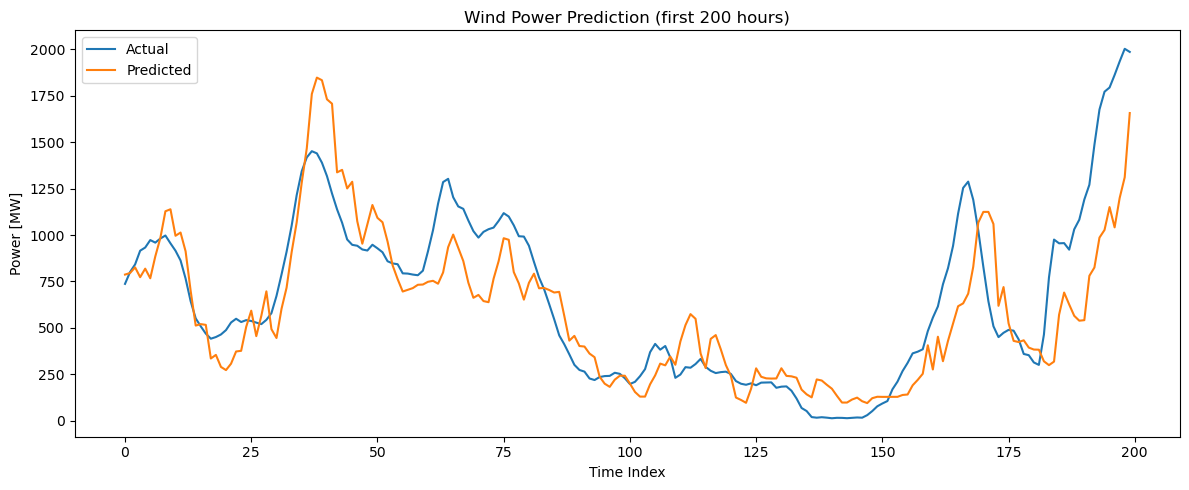

In [7]:
# 7. Visualization

plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label='Actual')
plt.plot(y_pred[:200], label='Predicted')
plt.legend()
plt.title('Wind Power Prediction (first 200 hours)')
plt.xlabel('Time Index')
plt.ylabel('Power [MW]')
plt.tight_layout()
plt.savefig('../plots/xgboost_results_01.png', dpi=500)
plt.show()

Improved RMSE: 358.68 MW
Improved R² Score: 0.68


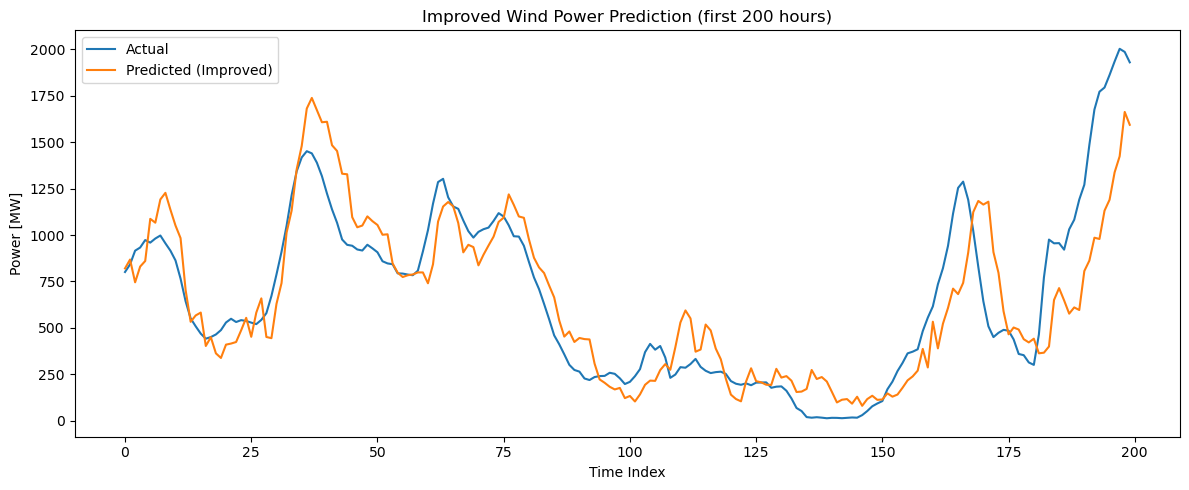

In [8]:
# 8. Improved Model with Advanced Features

# Feature engineering (extended)
df['lag3'] = df['windspeed_10m'].shift(3)
df['lag6'] = df['windspeed_10m'].shift(6)
df['rolling_mean_3'] = df['windspeed_10m'].rolling(3).mean()
df['delta_wind'] = df['windspeed_10m'] - df['lag1']

# Drop NA from rolling and lags
df.dropna(inplace=True)

# New feature list
features_improved = ['windspeed_10m', 'lag1', 'lag3', 'lag6', 'rolling_mean_3', 'delta_wind', 'hour', 'month', 'dayofweek']

# Train/test split
X_imp = df[features_improved]
y_imp = df['wind_power_actual']
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_imp, y_imp, test_size=0.2, shuffle=False)

# Train improved model
model_imp = XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=2, subsample=0.65, colsample_bytree=0.6)
model_imp.fit(X_train_imp, y_train_imp)
y_pred_imp = model_imp.predict(X_test_imp)

# Evaluate improved model
rmse_imp = mean_squared_error(y_test_imp, y_pred_imp, squared=False)
r2_imp = r2_score(y_test_imp, y_pred_imp)
print(f'Improved RMSE: {rmse_imp:.2f} MW')
print(f'Improved R² Score: {r2_imp:.2f}')

# Plot results
plt.figure(figsize=(12,5))
plt.plot(y_test_imp.values[:200], label='Actual')
plt.plot(y_pred_imp[:200], label='Predicted (Improved)')
plt.legend()
plt.title('Improved Wind Power Prediction (first 200 hours)')
plt.xlabel('Time Index')
plt.ylabel('Power [MW]')
plt.tight_layout()
plt.savefig('../plots/xgboost_results_02.png', dpi=500)
plt.show()


Further Improved RMSE: 367.09 MW
Further Improved R² Score: 0.67


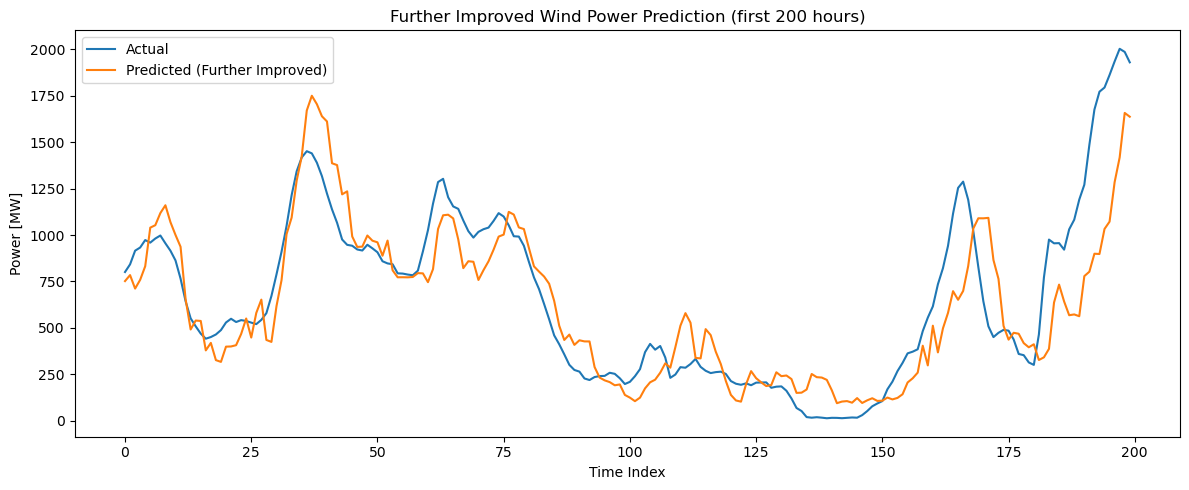

In [9]:
# 9. Further Model Enhancements

# Feature engineering - extended
df["windspeed_cubed"] = df["windspeed_10m"] ** 3                ##### This should be the most important one #####
df["wind_power_lag1"] = df["wind_power_actual"].shift(1)
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

# Add seasonal categories
df["season"] = df["month"].map({
    12: "winter", 1: "winter", 2: "winter",
    3: "spring", 4: "spring", 5: "spring",
    6: "summer", 7: "summer", 8: "summer",
    9: "fall", 10: "fall", 11: "fall"
})
df = pd.get_dummies(df, columns=["season"])

# Drop rows with NaN values from new features
df.dropna(inplace=True)

# Updated feature list
#features_further = [
#    'windspeed_10m', 'windspeed_cubed', 'lag1', 'lag3', 'lag6',
#    'rolling_mean_3', 'delta_wind', 'wind_power_lag1',
#    'hour', 'month', 'dayofweek', 'is_weekend',
#    'season_fall', 'season_spring', 'season_summer', 'season_winter'
#]

features_further = [
    'windspeed_10m', 'windspeed_cubed', 'lag1', 'lag3', 'lag6',
    'rolling_mean_3', 'delta_wind',
    'hour', 'month', 'dayofweek', 'is_weekend',
    'season_fall', 'season_spring', 'season_summer', 'season_winter'
]

# Split data
X_further = df[features_further]
y_further = df['wind_power_actual']
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_further, y_further, test_size=0.2, shuffle=False)

# Train improved model with modified hyperparameters
model_further = XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=3, subsample=0.7, colsample_bytree=0.7)
model_further.fit(X_train_f, y_train_f)
y_pred_f = model_further.predict(X_test_f)

# Save the model
joblib.dump(model_further, "../models/xgboost_model.pkl")

# Evaluation
rmse_f = mean_squared_error(y_test_f, y_pred_f, squared=False)
r2_f = r2_score(y_test_f, y_pred_f)
print(f'Further Improved RMSE: {rmse_f:.2f} MW')
print(f'Further Improved R² Score: {r2_f:.2f}')

# Plot
plt.figure(figsize=(12,5))
plt.plot(y_test_f.values[:200], label='Actual')
plt.plot(y_pred_f[:200], label='Predicted (Further Improved)')
plt.legend()
plt.title('Further Improved Wind Power Prediction (first 200 hours)')
plt.xlabel('Time Index')
plt.ylabel('Power [MW]')
plt.savefig('../plots/xgboost_results_03.png', dpi=500)
plt.tight_layout()
plt.show()

RMSE: 335.92 MW
R²: 0.72


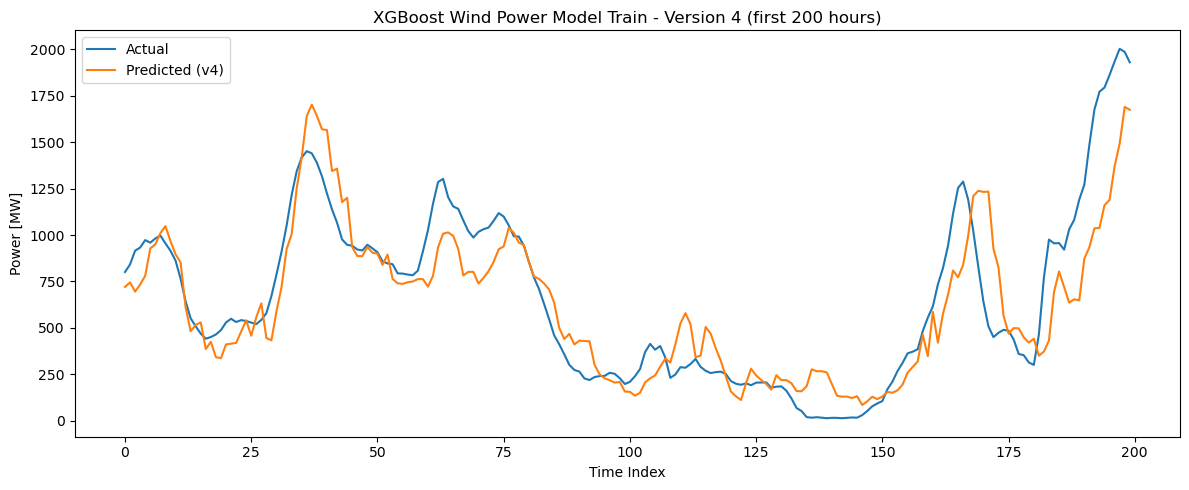

In [12]:
# XGBoost Version 4: Includes additional meteorological features such as wind direction, temperature, pressure, and humidity

# Load data
df = pd.read_csv("../data/merged_training_data_2016.csv", parse_dates=["timestamp"])
df.rename(columns={"DK_1_wind_onshore_generation_actual": "wind_power_actual"}, inplace=True)

# Time-based features
df["hour"] = df["timestamp"].dt.hour
df["month"] = df["timestamp"].dt.month
df["dayofweek"] = df["timestamp"].dt.dayofweek
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

# Lag and rolling features (on wind speed)
df["lag1"] = df["windspeed_10m"].shift(1)
df["lag3"] = df["windspeed_10m"].shift(3)
df["lag6"] = df["windspeed_10m"].shift(6)
df["rolling_mean_3"] = df["windspeed_10m"].rolling(window=3).mean()
df["delta_wind"] = df["windspeed_10m"] - df["lag1"]

# Wind speed cubed (very important feature)
df["windspeed_cubed"] = df["windspeed_10m"] ** 3

# Season as categorical feature
df["season"] = df["month"].map({
    12: "winter", 1: "winter", 2: "winter",
    3: "spring", 4: "spring", 5: "spring",
    6: "summer", 7: "summer", 8: "summer",
    9: "fall", 10: "fall", 11: "fall"
})
df = pd.get_dummies(df, columns=["season"])

# Drop rows with NaNs introduced by shifting and rolling
df.dropna(inplace=True)

# Feature list including wind direction, temperature, pressure, humidity
features_v4 = [
    'windspeed_10m', 'windspeed_cubed', 'lag1', 'lag3', 'lag6',
    'rolling_mean_3', 'delta_wind',
    'winddirection_10m', 'temperature_2m', 'surface_pressure', 'relativehumidity_2m',
    'hour', 'month', 'dayofweek', 'is_weekend',
    'season_fall', 'season_spring', 'season_summer', 'season_winter'
]

# Train-test split
X = df[features_v4]
y = df["wind_power_actual"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train XGBoost model
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    n_jobs=-1,
    early_stopping_rounds=20
)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Save model
joblib.dump(model, "../models/xgboost_model.pkl")

# Predict and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f} MW")
print(f"R²: {r2:.2f}")

# Plot prediction vs actual
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label='Actual')
plt.plot(y_pred[:200], label='Predicted (v4)')
plt.legend()
plt.title('XGBoost Wind Power Model Train - Version 4 (first 200 hours)')
plt.xlabel('Time Index')
plt.ylabel('Power [MW]')
plt.tight_layout()
plt.savefig('../plots/xgboost_train_results.png', dpi=500)
plt.show()
